In [10]:
%pylab inline
import pandas as pd
import seaborn as sns

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


# Logistic regression exercise with Titanic data

## Introduction

- Data from Kaggle's Titanic competition: [data](https://github.com/justmarkham/DAT8/blob/master/data/titanic.csv), [data dictionary](https://www.kaggle.com/c/titanic/data)
- **Goal**: Predict survival based on passenger characteristics
- `titanic.csv` is already in our repo, so there is no need to download the data from the Kaggle website

## Read the data into Pandas

In [11]:
url = '../data/titanic.csv'
titanic = pd.read_csv(url, index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
titanic.shape

(891, 11)

### Dealing with missing values

In [36]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Here we use **median imputation** to fill in the missing values. Other methods include:
 - dropping all rows with NAs
 - imputing with mean / mode
 - building a kNN model for imputation
 
Sometimes we want to treat NAs as **another category in itself** (**Question**: Why might this be the case?)

In [37]:
# fill missing values for Age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

### Handling categorical features

How do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

In [41]:
# encode Sex_Female feature
titanic['Sex_Female'] = titanic.Sex.map({'male':0, 'female':1})

In [42]:
# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

- How do we **interpret** the encoding for Embarked?
- Why didn't we just encode Embarked using a **single feature** (C=0, Q=1, S=2)?
- Does it matter which category we choose to define as the **baseline**?
- Why do we only need **two dummy variables** for Embarked?

### Did the data preparation for `Sex` and `Embarked` make a difference?

Lets first try training a model without it, where **survived** is the response.

In [53]:
# define X and y
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived

# train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# Confirm that the coefficients make intuitive sense.
print(dict(zip(feature_cols, logreg.coef_[0])))

# calculate testing accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

{'Pclass': -0.88188860564509608, 'Parch': 0.3423921585749839}
0.668161434978


### Compare against baseline

In [17]:
# this works regardless of the number of classes
y_test.value_counts().head(1) / len(y_test)

0    0.573991
Name: Survived, dtype: float64

### What happens when we add in the features we cleaned up?

In [57]:
# define X and y
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

# train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# Confirm that the coefficients make intuitive sense.
print(dict(zip(feature_cols, logreg.coef_[0])))

# calculate testing accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

{'Parch': -0.088136409819910083, 'Sex_Female': 2.6387651506051784, 'Pclass': -1.1852139631794056, 'Embarked_S': -0.60034899171563505, 'Embarked_Q': -0.20839670509963779, 'Age': -0.039708856430598329}
0.793721973094


More than 12% better! We also learned some interesting things, such as:
- `age` has little to do with surviving
- Being female gives you a significantly better chance of surviving, your log-odds increase by 2.638 i.e. your odds are: 

In [58]:
exp(2.638765)

13.995907983524319

14 times better!

# Diagnosing classification models: confusion matrices and ROC curves

In [59]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

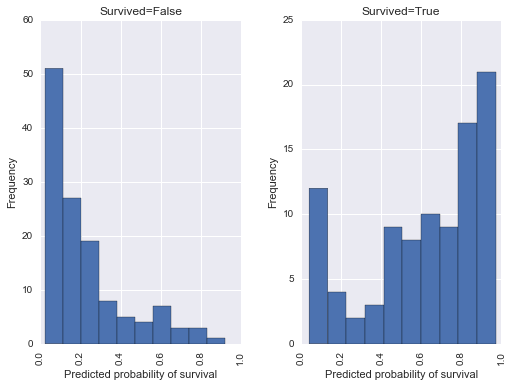

In [60]:
labels_preds = pd.DataFrame({'label': y_test, 'pred_prob': y_pred_prob})
axs = labels_preds.hist(by='label', column='pred_prob', sharex=True)
for i, ax in enumerate(axs):
    ax.set_title('Survived=' + str(bool(i)))
    ax.set_xlim(0, 1)
    ax.set_xlabel('Predicted probability of survival')
    ax.set_ylabel('Frequency')
plt.show()

In [61]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

[[111  17]
 [ 29  66]]


In [62]:
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

In [63]:
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

True Positives: 66
True Negatives: 111
False Positives: 17
False Negatives: 29


In [64]:
# increase sensitivity by lowering the threshold for predicting survival
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.3, 1, 0)

In [65]:
# old confusion matrix, sensitivity, and specificity
print(confusion)
# calculate the sensitivity
print('Sensitivity: ', TP / float(TP + FN))
# calculate the specificity
print('Specificity: ', TN / float(TN + FP))

[[111  17]
 [ 29  66]]
Sensitivity:  0.694736842105
Specificity:  0.8671875


In [66]:
# new confusion matrix
new_confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(new_confusion)
# calculate the sensitivity
print('Sensitivity: ', new_confusion[1][1] / float(sum(new_confusion[1])))
# calculate the specificity
print('Specificity: ', new_confusion[0][0] / float(sum(new_confusion[0])))

[[98 30]
 [17 78]]
Sensitivity:  0.821052631579
Specificity:  0.765625


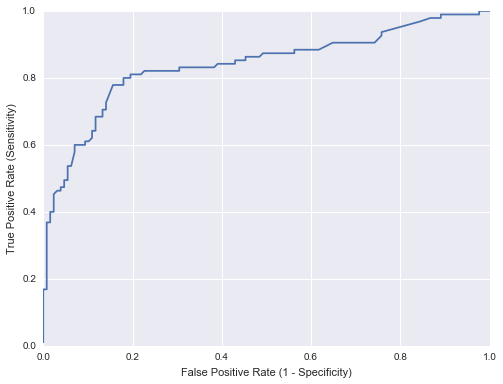

In [70]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [69]:
# calculate AUC
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.838692434211
